# CNN 練習

## 匯入所需套件

In [1]:
# 檢查有沒有 GPU
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [2]:
# import package
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline

## Cifar10 資料讀入及前處理
- 總共有10類

# <img src="cifar10_classes.jpeg" width=500  /> 

In [3]:
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('x_train shape:', x_train.shape)
print('y_train.shape:', y_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# x_train.shape:四個維度：第1維度為筆數、第2,3維度為影像大小32*32、第4維度是RGB三原色，所以是3
# x_train中有50000筆訓練資料，以及x_test中有10000筆的測試資料

x_train shape: (50000, 32, 32, 3)
y_train.shape: (50000, 1)
50000 train samples
10000 test samples


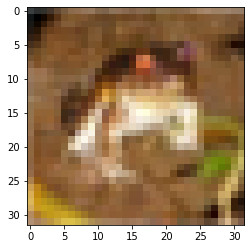

In [6]:
# show the first image of training data
plt.grid(False)
plt.imshow(x_train[0])

In [7]:
y_train[0] # 第0筆圖像資料分類的位置

array([6], dtype=uint8)

In [12]:
#x_train[0]

In [10]:
# image preprocessing
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# 將features(照片影像特徵值)標準化，可以提高模型預測的準確度，並且更快收斂
# 限縮範圍
x_train /= 255  # rescaling 
x_test /= 255  # rescaling

In [7]:
#plt.imshow(x_train[0])

In [8]:
y_train[0:10] # 0:10筆的類別

array([[6],
       [9],
       [9],
       [4],
       [1],
       [1],
       [2],
       [7],
       [8],
       [3]], dtype=uint8)

## one hot encode

In [9]:
keras.utils.to_categorical(y_train[0:10]) # 對0:10筆的類別做one_hot

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [10]:
# 將訓練資料與測試資料的label，進行Onehot encoding轉換
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

y_train shape: (50000, 10)
y_test shape: (10000, 10)


In [11]:
## result's dictionary
model_result = dict()
model_result['acc'] = dict()
model_result['loss'] = dict()
model_result['val_acc'] = dict()
model_result['val_loss'] = dict()

## 模型定義

In [12]:
def build_model(cnn=False):

    if cnn:
        # 選擇Sequential 次序性為這次深度學習模型
        model = Sequential()

        # 建立卷積層，設定32個3*3的filters
        # padding設定為same，讓卷積運算，產生的卷積影像大小不變
        # 設定ReLU為激活函數。

        model.add(Conv2D(32, (3, 3), padding='same',
                       input_shape=x_train.shape[1:]))
        model.add(BatchNormalization())# 在每個批次上將前一層的激活值正規化，提升效能
        model.add(Activation('relu'))
        model.add(Dropout(0.25)) # 避免overfitting

        # 第二層 - 卷積層 + 池化層
        # maxpooling收斂卷積完的結果
        model.add(Conv2D(32, (3, 3)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        # 第三層 - 卷積層
        model.add(Conv2D(64, (3, 3), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))

        # 第四層 - 卷積層 + 池化層
        model.add(Conv2D(64, (3, 3)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25)) # 避免overfitting

        # 建立分類模型 (MLP) : 平坦層 + 隱藏層 (512 神經元) + 輸出層 (10)
        model.add(Flatten())
        model.add(Dense(512))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(0.25)) # 避免overfitting
        model.add(Dense(num_classes))
        model.add(Activation('softmax'))

    else:
        model = Sequential()

        model.add(Flatten(input_shape=x_train.shape[1:]))

        model.add(Dense(512))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(0.25))

        model.add(Dense(256))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(0.25))

        model.add(Dense(128))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(0.25))

        model.add(Dense(num_classes))
        model.add(Activation('softmax'))
    
    return model

In [13]:
dnn_model = build_model(cnn=False)
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1573376   
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1

In [14]:
cnn_model = build_model(cnn=True)
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_3 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_4 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
batch_normalization_4 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
activation_5 (Activation)    (None, 30, 30, 32)       

## 開始訓練模型

In [15]:
batch_size = 32
epochs = 10

# 編譯模型
# 選用Adam為optimizer 
optimizer = keras.optimizers.Adam()

dnn_model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

dnn_model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test),
          shuffle=True)

# 儲存訓練結果

experiment = 'DNN'

model_result['acc'][experiment] = dnn_model.history.history.get('accuracy')
model_result['val_acc'][experiment] = dnn_model.history.history.get('val_accuracy')
model_result['loss'][experiment] = dnn_model.history.history.get('loss')
model_result['val_loss'][experiment] = dnn_model.history.history.get('val_loss')

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 11s 210us/sample - loss: 1.8019 - accuracy: 0.3542 - val_loss: 1.7395 - val_accuracy: 0.3731
Epoch 2/10
50000/50000 [==============================] - 9s 170us/sample - loss: 1.5926 - accuracy: 0.4325 - val_loss: 1.6350 - val_accuracy: 0.4035
Epoch 3/10
50000/50000 [==============================] - 9s 170us/sample - loss: 1.5202 - accuracy: 0.4601 - val_loss: 1.5116 - val_accuracy: 0.4656
Epoch 4/10
50000/50000 [==============================] - 8s 169us/sample - loss: 1.4637 - accuracy: 0.4789 - val_loss: 1.4817 - val_accuracy: 0.4734
Epoch 5/10
50000/50000 [==============================] - 8s 168us/sample - loss: 1.4177 - accuracy: 0.4957 - val_loss: 1.4118 - val_accuracy: 0.4980
Epoch 6/10
50000/50000 [==============================] - 8s 167us/sample - loss: 1.3782 - accuracy: 0.5103 - val_loss: 1.5194 - val_accuracy: 0.4542
Epoch 7/10
50000/50000 [=========================

In [16]:
batch_size = 32
epochs = 10

# 編譯模型
# 選用Adam為optimizer 
optimizer = keras.optimizers.Adam()

cnn_model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

cnn_model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test),
          shuffle=True)

# 儲存訓練結果

experiment = 'CNN'

model_result['acc'][experiment] = cnn_model.history.history.get('accuracy')
model_result['val_acc'][experiment] = cnn_model.history.history.get('val_accuracy')
model_result['loss'][experiment] = cnn_model.history.history.get('loss')
model_result['val_loss'][experiment] = cnn_model.history.history.get('val_loss')

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 12s 250us/sample - loss: 1.3424 - accuracy: 0.5268 - val_loss: 1.0417 - val_accuracy: 0.6325
Epoch 2/10
50000/50000 [==============================] - 9s 187us/sample - loss: 0.9200 - accuracy: 0.6775 - val_loss: 0.9077 - val_accuracy: 0.6794
Epoch 3/10
50000/50000 [==============================] - 9s 188us/sample - loss: 0.7757 - accuracy: 0.7284 - val_loss: 0.6695 - val_accuracy: 0.7664
Epoch 4/10
50000/50000 [==============================] - 9s 188us/sample - loss: 0.6751 - accuracy: 0.7643 - val_loss: 0.7756 - val_accuracy: 0.7300
Epoch 5/10
50000/50000 [==============================] - 9s 187us/sample - loss: 0.6135 - accuracy: 0.7856 - val_loss: 0.9609 - val_accuracy: 0.6673
Epoch 6/10
50000/50000 [==============================] - 9s 189us/sample - loss: 0.5490 - accuracy: 0.8075 - val_loss: 0.6509 - val_accuracy: 0.7788
Epoch 7/10
50000/50000 [=========================

# show 結果

prediction:  [3]


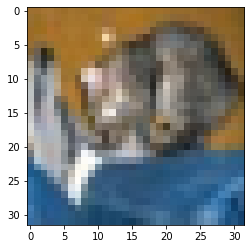

In [18]:
test_pred = cnn_model.predict(x_test[0:1]).argmax(-1)

plt.imshow(x_test[0])
print('prediction: ', test_pred)

## 訓練結果視覺化

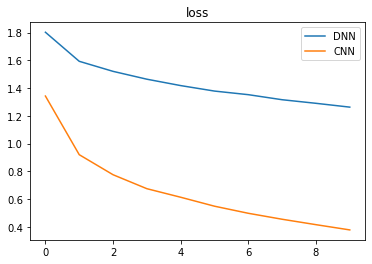

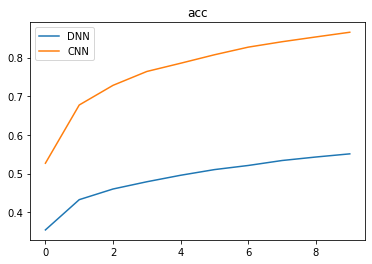

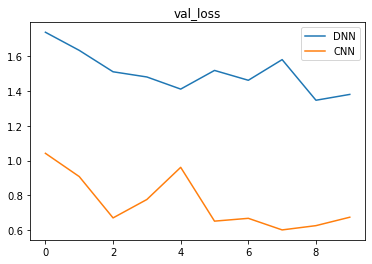

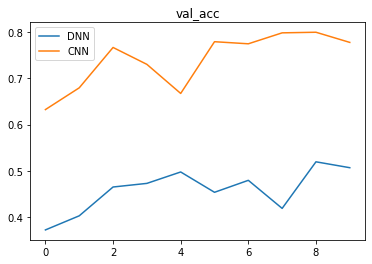

In [19]:
import matplotlib.pyplot as plt

# training loss
for i in model_result['loss'].keys():
    plt.plot(np.arange(len(model_result['loss'][i])), model_result['loss'][i], label = i)

plt.legend(loc='best')
plt.title('loss')
plt.show()

# training acc
for i in model_result['acc'].keys():
    plt.plot(np.arange(len(model_result['acc'][i])), model_result['acc'][i], label = i)

plt.legend(loc='best')
plt.title('acc')
plt.show()

# valid loss
for i in model_result['val_loss'].keys():
    plt.plot(np.arange(len(model_result['val_loss'][i])), model_result['val_loss'][i], label = i)

plt.legend(loc='best')
plt.title('val_loss')
plt.show()


# valid acc
for i in model_result['val_acc'].keys():
    plt.plot(np.arange(len(model_result['val_acc'][i])), model_result['val_acc'][i], label = i)

plt.legend(loc='best')
plt.title('val_acc')
plt.show()

# CNN 適合做圖像的提取特徵
# CNN 考慮了圖像的空間關係

# CNN 補充資料
https://medium.com/jameslearningnote/%E8%B3%87%E6%96%99%E5%88%86%E6%9E%90-%E6%A9%9F%E5%99%A8%E5%AD%B8%E7%BF%92-%E7%AC%AC5-1%E8%AC%9B-%E5%8D%B7%E7%A9%8D%E7%A5%9E%E7%B6%93%E7%B6%B2%E7%B5%A1%E4%BB%8B%E7%B4%B9-convolutional-neural-network-4f8249d65d4f

https://medium.com/@syshen/%E5%85%A5%E9%96%80%E6%B7%B1%E5%BA%A6%E5%AD%B8%E7%BF%92-2-d694cad7d1e5